### Score: `[44]`

1.1 `[13]` 注意文献中的值

1.2 `[20]` Good job!

1.3 `[4]` 图很好看，但是注意前面参数错了

[Bonus] `[7]` 初始值跟文献对不上

各题批注用`### Note`给出，请自行查阅。

1. Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in Tomizuka 2009.

1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

[Bonus] [10 points] Following equation 5-13, compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).

Useful data sets:

Global Fossil-Fuel CO2 Emissions
Mauna Loa CO2 annual mean data
Historical CO2 Records from the Law Dome DE08, DE08-2, and DSS Ice Cores
Source:
Tomizuka (2009), Is a box model effective for understanding the carbon cycle?, American Journal of Physics, 77, 156, doi: 10.1119/1.3013196.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [ ]:
#先把文件转换一下格式

# Read the file content
file_path = 'global.1751_2014.ems'

with open(file_path, 'r') as file:
    file_content = file.readlines()

# Extracting relevant data lines (from line 40 onwards) and parsing it into a DataFrame
data_lines = file_content[40:]

# Splitting each line by whitespace to create columns and removing any empty lines
data_rows = [line.split() for line in data_lines if line.strip()]

# Define the column names based on the data preview
columns = ['Year', 'Total', 'Gas', 'Liquids', 'Solids', 'Cement Production', 'Gas Flaring', 'Per Capita']

# Create a DataFrame from the rows and columns
df = pd.DataFrame(data_rows, columns=columns)

# Convert the DataFrame to CSV format
csv_file_path = 'global.1751_2014.csv'
df.to_csv(csv_file_path, index=False)

# Optional: Display the DataFrame to confirm it's correct
print(df.head())


In [2]:
# 读取输入数据
global_data = pd.read_csv('co2_annmean_gl.csv')
mlo_data = pd.read_csv('co2_annmean_mlo.csv')
historical_data = pd.read_csv('global.1751_2014.csv')


In [3]:
# 根据 Tomizuka 2009 得到参数
k12 = 70 / 740    # 大气到海洋的传输系数
k21 = 70 / 900    # 海洋到大气的传输系数
N1_0_no_buffer = 740    # 无缓冲效应初始大气碳含量 (PgC)
N1_0_with_buffer = 780    # 有缓冲效应初始海洋碳含量 (PgC)
N2_0 = 900  # 初始海洋表层碳含量 (PgC)
beta = 2.5          # 缓冲因子 (假设值)

### Note:
## k12 = 105 / 740, k21 = 102 / 900

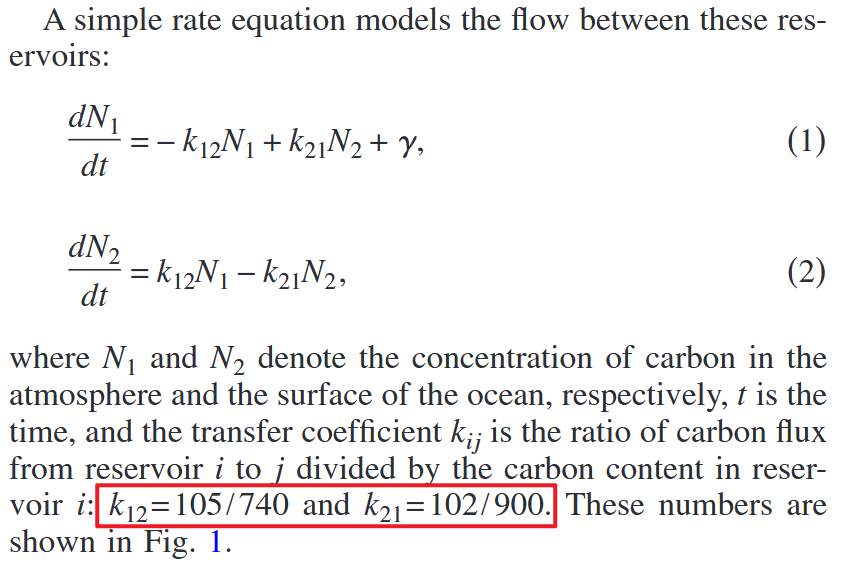

In [4]:
# 提取数据并进行单位转换
def extract_emissions(start_year, end_year):
    emissions = historical_data[(historical_data['Year'] >= start_year) & (historical_data['Year'] <= end_year)]
    emissions = emissions['Total'].values * 1e-3  # 转换为PgC
    if len(emissions) < (end_year - start_year + 1):
        raise ValueError("Emission data is incomplete for the given year range.")
    return emissions

1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [5]:
# 1. 不考虑缓冲效应的两箱模型
def two_box_model_no_buffer(years=np.arange(1987, 2005)):
    dt = 1  # 时间步长 (1年)
    N1 = [N1_0_no_buffer]  # 大气碳含量初始值（无缓冲效应）
    N2 = [N2_0]  # 海洋表层碳含量初始值
    emissions = extract_emissions(years[0], years[-1])  # 提取人为碳排放数据
    
    for t in range(1, len(years)):
        gamma = emissions[t - 1] if t - 1 < len(emissions) else emissions[-1]  # 取当前年份的排放量
        dN1_dt = -k12 * N1[-1] + k21 * N2[-1] + gamma
        dN2_dt = k12 * N1[-1] - k21 * N2[-1]
        
        # 防止异常值
        N1_new = max(N1[-1] + dN1_dt * dt, 0)
        N2_new = max(N2[-1] + dN2_dt * dt, 0)
        N1.append(N1_new)
        N2.append(N2_new)
    
    # 转换为ppm
    CO2_ppm = np.array(N1) / 2.13
    return years, CO2_ppm

In [6]:
years, CO2_no_buffer = two_box_model_no_buffer()

1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [7]:
# 2. 考虑缓冲效应的两箱模型
def two_box_model_with_buffer(years=np.arange(1987, 2005)):
    dt = 1  # 时间步长 (1年)
    N1 = [N1_0_with_buffer]  # 大气碳含量初始值（有缓冲效应）
    N2 = [N2_0]  # 海洋表层碳含量初始值
    emissions = extract_emissions(years[0], years[-1])  # 提取人为碳排放数据
    
    for t in range(1, len(years)):
        gamma = emissions[t - 1] if t - 1 < len(emissions) else emissions[-1]  # 取当前年份的排放量
        dN1_dt = -k12 * N1[-1] + k21 * (N2_0 + beta * (N2[-1] - N2_0)) + gamma
        dN2_dt = k12 * N1[-1] - k21 * (N2_0 + beta * (N2[-1] - N2_0))
        
        # 防止异常值
        N1_new = max(N1[-1] + dN1_dt * dt, 0)
        N2_new = max(N2[-1] + dN2_dt * dt, 0)
        N1.append(N1_new)
        N2.append(N2_new)
    
    # 转换为ppm
    CO2_ppm = np.array(N1) / 2.13
    return years, CO2_ppm

In [8]:
years, CO2_with_buffer = two_box_model_with_buffer()

1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

In [9]:
years, CO2_no_buffer = two_box_model_no_buffer()
years, CO2_with_buffer = two_box_model_with_buffer()

# 读取观测数据（Mauna Loa）
mlo_observed = mlo_data[(mlo_data['year'] >= 1987) & (mlo_data['year'] <= 2004)]


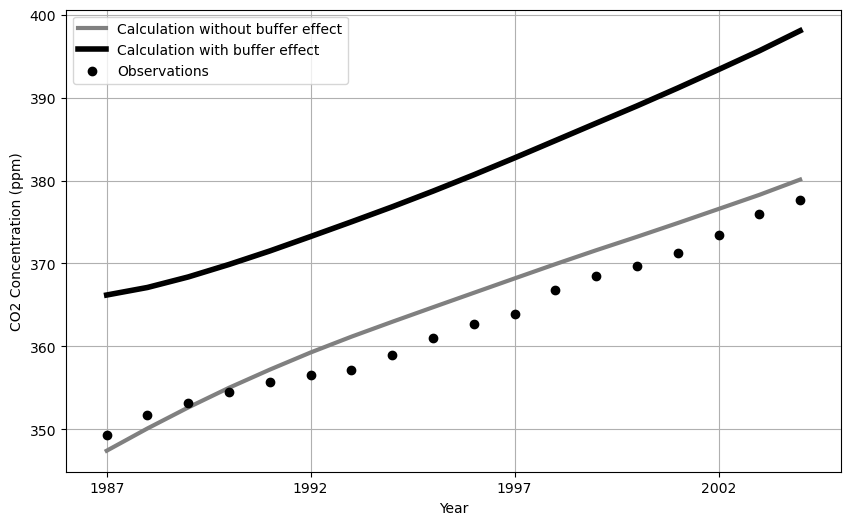

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(years, CO2_no_buffer, label='Calculation without buffer effect', linestyle='-', color='gray', linewidth=3)
plt.plot(years, CO2_with_buffer, label='Calculation with buffer effect', linestyle='-', color='black', linewidth=4)
plt.scatter(mlo_observed['year'], mlo_observed['mean'], color='black', label='Observations', zorder=5)
plt.xticks(np.arange(1987, 2005, 5)) 
plt.xlim(1986, 2005)  
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid()
plt.show()

[Bonus] [10 points] Following equation 5-13, compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).

Useful data sets:

In [21]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [22]:
data = pd.read_csv("Global_land-use_flux-1850_2005.csv")

In [23]:
# 加载数据，并将单位从MtC转换为PgC

data['Global'] = data['Global'] * 1e-3  # MtC 转换为 PgC
years = data['Year'].values  # 提取年份
global_flux = data['Global'].values.cumsum()  # 计算累计碳排放量

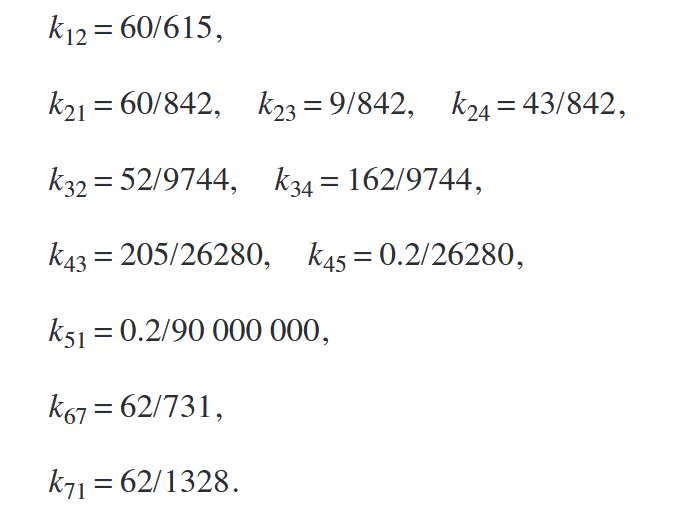

In [24]:
### Note：初始条件是不是不太对

#定义七箱碳循环模型的参数和初始条件
# 碳传输系数 (kij)，单位：年^-1
k12 = 60 / 740
k21 = 60 / 900
k23 = 9 / 900
k32 = 52 / 10000
k24 = 43 / 900
k34 = 162 / 10000
k43 = 205 / 30000
k45 = 0.2 / 30000
k51 = 0.2 / 90000000
k67 = 62 / 730
k71 = 62 / 1328

# 初始碳储量 (PgC)，对应于工业化前状态
N1_0 = 740  # 大气碳含量
N2_0 = 900  # 海洋表层碳储量
N3_0 = 10000  # 海洋中层碳储量
N4_0 = 30000  # 海洋深层碳储量
N5_0 = 90000000  # 沉积物碳储量
N6_0 = 730  # 陆地生物圈碳储量
N7_0 = 1328  # 土壤碳储量

# 碳肥效应参数 β
beta_values = [0.38, 0.50] 

# 转换因子：PgC 转 ppm
conversion_factor = 2.13

In [25]:
# 定义七箱碳循环模型的微分方程组
def seven_box_model(t, N, beta):
    N1, N2, N3, N4, N5, N6, N7 = N
    # 从累计碳排放量中插值获取当前年份的土地利用排放量
    gamma = np.interp(t, years, global_flux)
    # 碳肥效应对陆地生物圈碳吸收的影响
    f = 62 * (1 + beta * np.log(max(N1 / N1_0, 1e-8)))
    # 土地利用通量分配：一半进入大气，另一半进入土壤
    delta = gamma / 2

    # 定义方程组
    dN1_dt = -k12 * N1 + k21 * (N2_0 + beta * (N2 - N2_0)) + gamma - f + delta + k51 * N5 + k71 * N7
    dN2_dt = k12 * N1 - k21 * (N2_0 + beta * (N2 - N2_0)) - k23 * N2 + k32 * N3 - k24 * N2
    dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
    dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
    dN5_dt = k45 * N4 - k51 * N5
    dN6_dt = f - k67 * N6 - 2 * delta
    dN7_dt = k67 * N6 - k71 * N7 + delta

    return [dN1_dt, dN2_dt, dN3_dt, dN4_dt, dN5_dt, dN6_dt, dN7_dt]

# 对方程进行数值求解，计算不同β值下的大气CO₂浓度
results = {}
for beta in beta_values:
    solution = solve_ivp(seven_box_model, [years[0], years[-1]],
                         [N1_0, N2_0, N3_0, N4_0, N5_0, N6_0, N7_0],
                         t_eval=years, args=(beta,), method='RK45')
    # 将大气碳储量 (PgC) 转换为 CO₂ 浓度 (ppm)
    results[beta] = solution.y[0] / conversion_factor




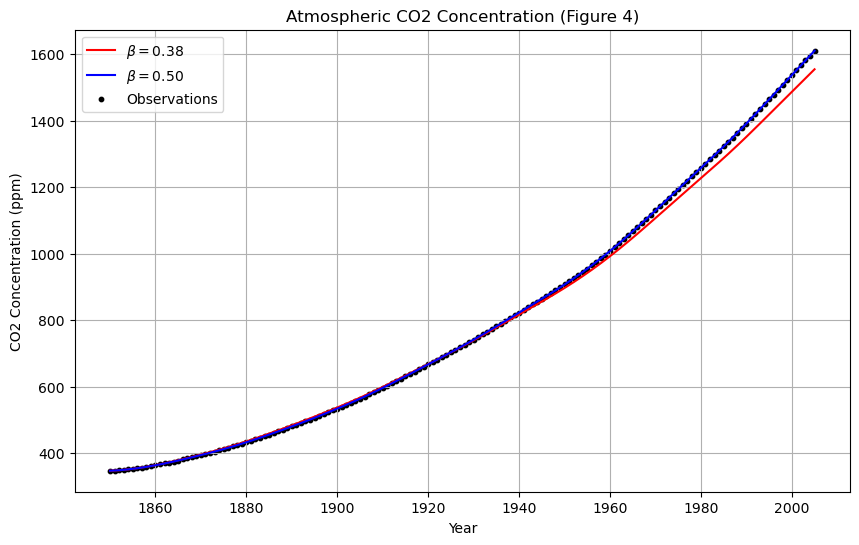

In [26]:
# 绘制Figure 4
plt.figure(figsize=(10, 6))
plt.plot(years, results[0.38], label=r'$β = 0.38$', color='red')  # β=0.38
plt.plot(years, results[0.50], label=r'$β = 0.50$', color='blue')  # β=0.50
plt.scatter(years, results[0.50], color='k', s=10, label='Observations')  # 观测数据
plt.title('Atmospheric CO2 Concentration (Figure 4)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid()
plt.show()